#### Part One: Word Representations using Word2Vec Architecture


Steps
* Data Collection
* Data Preparation:  Vocabulary
* Modeling
* Training
* Testing pre-trained models
* Visualizing




In [ ]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/dtywyf3sth-1.zip

--2022-01-28 23:15:47--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/dtywyf3sth-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.98.112
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.98.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 416078273 (397M) [application/zip]
Saving to: ‘dtywyf3sth-1.zip’

dtywyf3sth-1.zip    100%[===================>] 396.80M  11.8MB/s    in 38s     

2022-01-28 23:16:26 (10.6 MB/s) - ‘dtywyf3sth-1.zip’ saved [416078273/416078273]



In [ ]:
!unzip dtywyf3sth-1.zip
!tar -xf dtywyf3sth-1/am-model-corpus.tar.gz
!rm dtywyf3sth-1.zip
!rm -r dtywyf3sth-1

Archive:  dtywyf3sth-1.zip
  inflating: dtywyf3sth-1/am-model-corpus.tar.gz  


### 

In [ ]:
!ls

amharic.zip  dataset  sample_data


In [2]:
import pandas as pd

In [3]:
import os

To use the entire data use the bellow code.
```
filenames = os.listdir('am-model-corpus/')
sent_per_line = []
for filename in filenames:
        with open(os.path.join("am-model-corpus/",filename)) as infile:
            contents = infile.read()
            sent_per_line.extend(contents)
print(f"{len(sent_per_line)} sentences total.")
print(f" \n sample sentenes {sent_per_line[:5]}")
```

In [ ]:
# #because of memory issues I will be using only testing data
# sent_per_line = []
# with open(os.path.join("am-model-corpus/",'test.txt')) as infile:
#   contents = infile.readlines()
# print(f"{len(contents)} sentences total.")
# print(f" \n sample sentenes {contents[:5]}")

322037 sentences total.
 
 sample sentenes ['የትግራይ ክልል መንግስት ሚዲያዎች ስለ በረከት መታሰር የዘገቡት አስገራሚ ዘገባ ።\n', 'የእርቅ ሃሳቡንም ለጠ ሚ ዶ ር ዐቢይ አህመድ አወያይተናቸው ፣ ጥሩ ስራ ነው ፤ የኛም ሃሳብ ይሄው ነው ፣ እንደግፋችኋለን ብለውን ነው፣ ወደ ኢትዮጵያ የመጣነው ፡፡\n', 'በስተመጨረሻም ቃለ መሃላ እና የስልጣን ውል በዚህ ሁኔታ ተፈጽሟል ፡፡\n', 'ከማፍረስ በቀር መገንባት እይደለም የሰ ።\n', 'ጃዋርን እኔም ዶ/ር ዓብይም ይቅር ልንለው አንችልም via YouTube ።\n']


### Data Preparation

Here is sample code to apply [amharic preprocessing](https://abe2g.github.io/am-preprocess.html)
or use [amseg](https://pypi.org/project/amseg/) tool.

### Using Gensim to train wrod embedding

In [ ]:
import logging
import os
from gensim.models import Word2Vec,KeyedVectors
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
!mkdir Model

In [ ]:
EMBEDDING_DIR='Model/'
DATA_DIR='am-model-corpus/'

In [ ]:

class WordEmbeddingConfig(object):
    """Word2Vec Training parameters"""
    window=5 #Maximum skip length window between words
    emb_dim=200 # Set size of word vectors
    emb_lr=0.05 #learning rate for SGD estimation.
    nepoach=1 #number of training epochs
    nthread=100 #number of training threads
    sample = 0 #Set threshold for occurrence of words. Those that appear with higher frequency in the training data will be randomly down-sampled
    negative = 10 #negative sampling is used with defined negative example
    hs = 0 #0 Use Hierarchical Softmax; default is 0 (not used)
    binary=0 # 0 means not saved as .bin. Change to 1 if allowed to binary format
    sg=0 # 0 means CBOW model is used. Change to 1 to use Skip-gram model
    iterate=2 # Run more training iterations
    minFreq=5 #This will discard words that appear less than minFreq times 
    if sg==0:
        model_name='cbow_'+str(emb_dim)+'D'
    elif sg==1:
         model_name='sg_'+str(emb_dim)+'D'

class DataGenerator(object):# accept sentence stored one per line in list of files inside defined directory
    def __init__(self, dirname):
        self.dirname = dirname
    
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in open(os.path.join(self.dirname, fname),encoding='utf8'):
                yield line.split()
    
def train_w2v_model():
    print('Loading Sentences with memory freindly iterator ...\n')
    sentences = DataGenerator(DATA_DIR) # a memory-friendly iterator 
    if WordEmbeddingConfig.sg==0:
            model_type='CBOW'
    else:
        model_type='Skip-gram'    
    print('Training Word2Vec '+model_type+' with '+str(WordEmbeddingConfig.emb_dim)+' dimension\n') 
    _model = Word2Vec(sentences, size=WordEmbeddingConfig.emb_dim, window=WordEmbeddingConfig.window, 
                            min_count=WordEmbeddingConfig.minFreq, workers=WordEmbeddingConfig.nthread,sg=WordEmbeddingConfig.sg,
                            iter=WordEmbeddingConfig.iterate,negative=WordEmbeddingConfig.negative,sample=WordEmbeddingConfig.sample,
                            hs=WordEmbeddingConfig.hs,sorted_vocab=1)
  
    #trim unneeded model memory = use (much) less RAM
    _model.init_sims(replace=True)
    
    #Saving model   
    model_name=EMBEDDING_DIR+WordEmbeddingConfig.model_name
    _model.save(model_name)

    return _model        
train_w2v_model()

2022-01-28 23:37:07,410 : INFO : collecting all words and their counts
2022-01-28 23:37:07,412 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-01-28 23:37:07,494 : INFO : PROGRESS: at sentence #10000, processed 163209 words, keeping 51331 word types
2022-01-28 23:37:07,587 : INFO : PROGRESS: at sentence #20000, processed 326526 words, keeping 84083 word types


Loading Sentences with memory freindly iterator ...

Training Word2Vec CBOW with 200 dimension



2022-01-28 23:37:07,691 : INFO : PROGRESS: at sentence #30000, processed 489729 words, keeping 111217 word types
2022-01-28 23:37:07,779 : INFO : PROGRESS: at sentence #40000, processed 649544 words, keeping 135062 word types
2022-01-28 23:37:07,881 : INFO : PROGRESS: at sentence #50000, processed 810186 words, keeping 157376 word types
2022-01-28 23:37:07,985 : INFO : PROGRESS: at sentence #60000, processed 972668 words, keeping 178197 word types
2022-01-28 23:37:08,078 : INFO : PROGRESS: at sentence #70000, processed 1135859 words, keeping 197816 word types
2022-01-28 23:37:08,168 : INFO : PROGRESS: at sentence #80000, processed 1298501 words, keeping 216297 word types
2022-01-28 23:37:08,256 : INFO : PROGRESS: at sentence #90000, processed 1460277 words, keeping 234163 word types
2022-01-28 23:37:08,349 : INFO : PROGRESS: at sentence #100000, processed 1624029 words, keeping 251579 word types
2022-01-28 23:37:08,439 : INFO : PROGRESS: at sentence #110000, processed 1785879 words, ke

In [ ]:
import gc
gc.collect()

265

### Loading pretrained word vectors

In [ ]:
from gensim.models import Word2Vec,KeyedVectors
am_model= KeyedVectors.load('Model/cbow_200D')

2022-01-29 00:02:02,054 : INFO : loading Word2VecKeyedVectors object from Model/cbow_200D
2022-01-29 00:02:03,849 : INFO : loading wv recursively from Model/cbow_200D.wv.* with mmap=None
2022-01-29 00:02:03,852 : INFO : loading vectors from Model/cbow_200D.wv.vectors.npy with mmap=None
2022-01-29 00:02:04,171 : INFO : setting ignored attribute vectors_norm to None
2022-01-29 00:02:04,173 : INFO : loading vocabulary recursively from Model/cbow_200D.vocabulary.* with mmap=None
2022-01-29 00:02:04,177 : INFO : loading trainables recursively from Model/cbow_200D.trainables.* with mmap=None
2022-01-29 00:02:04,179 : INFO : loading syn1neg from Model/cbow_200D.trainables.syn1neg.npy with mmap=None
2022-01-29 00:02:04,452 : INFO : setting ignored attribute cum_table to None
2022-01-29 00:02:04,453 : INFO : loaded Model/cbow_200D


In [ ]:
am_model.wv['ክልል']

array([ 1.13995392e-02, -8.75821710e-02, -2.26695873e-02,  7.16282055e-03,
       -7.86786005e-02, -7.72202909e-02, -4.32624668e-02, -3.62493694e-02,
       -1.65125296e-01,  6.80691972e-02,  1.22503527e-01,  1.15528433e-02,
        9.10150111e-02,  8.10150951e-02, -1.35743424e-01,  1.60751075e-01,
       -1.43242881e-01, -7.72720575e-02,  1.31575435e-01, -2.35465556e-01,
        7.41532817e-02,  7.30786771e-02, -2.83326544e-02, -4.01315317e-02,
        7.79516995e-02,  9.12770405e-02, -5.80229722e-02, -9.31174457e-02,
       -4.11611870e-02, -1.56805124e-02,  3.23570333e-02,  8.02358016e-02,
        1.25500575e-01,  5.30219451e-02,  1.32678375e-02,  2.41616182e-02,
        8.89523625e-02, -4.69238311e-02,  4.87189554e-02, -2.18194127e-02,
       -2.22914442e-02,  3.50087732e-02,  2.63706315e-02, -1.78961158e-01,
       -3.97473611e-02,  1.04040084e-02,  2.89472621e-02, -7.19870627e-02,
       -5.66749871e-02,  9.14055854e-03, -4.85350899e-02, -5.14077619e-02,
       -7.36861825e-02,  

#### How to evaluate word embeddings?
https://www.cs.cornell.edu/~schnabts/downloads/schnabel2015embeddings.pdf


* intrinsic methods
* extrinsic methods

In [ ]:
print(am_model.wv.doesnt_match("አንድ ሺህ ሚሊዮን አምስት ብዙ ጅማ".split()))
print(am_model.wv.doesnt_match("አንድ ሺህ ሚሊዮን አምስት ብዙ".split()))
print(am_model.wv.doesnt_match("ጥረቶች ተግባራት ቋንቋዎች ክንዋኔዎች".split()))
print(am_model.wv.most_similar_cosmul(positive=['ችግር', 'አገልግሎቶች'], negative=['አገልግሎት']))
print(am_model.wv.most_similar_cosmul(positive=['ቱርክ', 'አፍሪቃ'], negative=['ኢትዮጵያ']))
print(am_model.wv.most_similar_cosmul(positive=['እናት', 'አባቶች'], negative=['አባት']))
print(am_model.wv.most_similar_cosmul(positive=['ውጤት', 'ምርታማነት'], negative=['ምርት']))
print('Total Vocab: ',len(am_model.wv.vocab))

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


ጅማ
ብዙ
ቋንቋዎች
[('ችግሮች', 1.0238146781921387), ('ችግርም', 0.9964650869369507), ('ችግሮቻችን', 0.9903786182403564), ('ቀውሶች', 0.9685245752334595), ('ጉድለት', 0.9567131996154785), ('ችግሮችም', 0.9528098106384277), ('ችግሮችን', 0.9486801624298096), ('ጉድለቶች', 0.9477841258049011), ('ችግሮቹ', 0.9449748992919922), ('ችግርና', 0.9436498880386353)]
[('ዩክሬን', 1.0421923398971558), ('ዩክሬይን', 1.040156602859497), ('ሩስያ', 1.0395406484603882), ('ካሜሩን', 1.0368895530700684), ('አዉሮጳ', 1.0309395790100098), ('በማሊ', 1.0272736549377441), ('ፓኪስታን', 1.0213922262191772), ('ፈረንሳይ', 1.0193477869033813), ('አማፅያን', 1.0158940553665161), ('ሩሲያ', 1.0158363580703735)]
[('እናቶች', 0.8355720043182373), ('ወንድሞቻችን', 0.8325456380844116), ('ልጆቿ', 0.8305656909942627), ('እህቶቻችን', 0.8277310132980347), ('ምዕመናን', 0.8229623436927795), ('ልጆቻችን', 0.814708411693573), ('ወገኖቻችን', 0.8121797442436218), ('ዜጎቻችን', 0.8031029105186462), ('ወገኖቻቸው', 0.7992026805877686), ('ልጃገረዶች', 0.7988965511322021)]
[('ውጤትና', 0.9450569748878479), ('ውጤትን', 0.9428255558013916), ('ውጤታማነ

### Visualizing pre-trained word embedding models

In [ ]:
#list the vocabulary words
words = list(am_model.wv.vocab)
words

In [ ]:
# Get the interactive Tools for Matplotlib
### you can also use either plotly or tensorboard to visualize word vectors
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.family': 'cmr10'})
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA

X = am_model[am_model.wv.vocab]
pca = PCA(n_components=2)

result = pca.fit_transform(X)

# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(words):
   plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()

### Best Practices for morphologically rich languages
- Sub-word learning ([our amharic work](https://github.com/Abe2G/-Learning-Word-and-Sub-word-Vectors-for-Amharic-Less-Resourced-Language-)).
- Word2vec with character level models
- Concatinate word vectors with word classes (tags or any semantic info) vectors or add as auxulary input at attention layer
- Apply Depth-preprocessing 
Try with or without lowlevel word precessings (stemming, lematizer, ..)
- Sometimes character level models outperform by detecting misspeled words
- Use FastText or ELMO instead of word2vec











# PART TWO: Sequence-to-sequence (seq2seq) text modeling

### Sentence and document modeling

Next we will compare several seq2seq models to solve classification problem.

we will be following common ``EMBED-ENCODE-ATTEND-PREDICT`` pipeline
- SimpleRNN
- LSTM/GRU
- Bi-directional RNN
- Adding attention layer
- Using Transformer (BERT)


For this section we will be using publicly available [Amharic-News-Text-classification-Dataset](https://arxiv.org/pdf/2103.05639.pdf)

**Required packages**

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## let's copy data first

In [5]:
!wget https://github.com/IsraelAbebe/An-Amharic-News-Text-classification-Dataset/raw/main/data/Amharic%20News%20Dataset.zip

--2022-01-29 06:57:26--  https://github.com/IsraelAbebe/An-Amharic-News-Text-classification-Dataset/raw/main/data/Amharic%20News%20Dataset.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IsraelAbebe/An-Amharic-News-Text-classification-Dataset/main/data/Amharic%20News%20Dataset.zip [following]
--2022-01-29 06:57:26--  https://raw.githubusercontent.com/IsraelAbebe/An-Amharic-News-Text-classification-Dataset/main/data/Amharic%20News%20Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48325845 (46M) [application/zip]
Saving to: ‘Amharic News Dataset.zip’

Amharic News Datase 100%[=====

## Unzip into data folder

In [6]:
!ls

'Amharic News Dataset.zip'   sample_data


In [8]:
!mkdir data
!unzip 'Amharic News Dataset.zip'
!mv 'Amharic News Dataset.csv' data/
!rm 'Amharic News Dataset.zip'

In [9]:
news_data = pd.read_csv('data/Amharic News Dataset.csv')
news_data.head()

,headline,category,date,views,article,link
0,የኦሊምፒክ ማጣሪያ ተሳታፊዎች የሚለዩበት ቻምፒዮና እየተካሄደ ይገኛል,ስፖርት,"January 14, 2021",2,ብርሃን ፈይሳየኢትዮጵያ ቦክስ ፌዴሬሽን በየዓመቱ የሚያዘጋጀው የክለቦች ቻ...,https://www.press.et/Ama/?p=39481
1,አዲስ ዘመን ድሮ,መዝናኛ,"December 28, 2020",4,የአዲስ ዘመን ጋዜጣ ቀደምት ዘገባዎች በእጅጉ ተነባቢ ዛሬም ላገኛቸው በ...,https://www.press.et/Ama/?p=38334
2,የአረንጓዴ ጎርፍ በጎ አድራጎት አምባሳደሮች ተሰየሙ,ስፖርት,"January 6, 2021",6,ቦጋለ አበበየአዲስ አበባ ከተማ አስተዳደር ስፖርት ኮሚሽን ከኢትዮጵያ አረ...,https://www.press.et/Ama/?p=39010
3,የሊጉ በቢዝነስ ሞዴል መመራት አበረታች ጅምር መሆኑ ተገለጸ,ስፖርት,"January 6, 2021",5,ብርሃን ፈይሳአዲስ አበባ፡- የኢትዮጵያ ፕሪምየር ሊግ በሼር ካምፓኒ እንዲ...,https://www.press.et/Ama/?p=39011
4,የኦሊምፒክ ሥራ አስፈፃሚው እስከ ቶኪዮ ኦሊምፒክ ማግስት ይቀጥላል,ስፖርት,"January 6, 2021",12,ቦጋለ አበበ የኢትዮጵያ ኦሊምፒክ ኮሚቴ አርባ አምስተኛ መደበኛ ጠቅላላ ጉ...,https://www.press.et/Ama/?p=39012


### Both text preprocessing and exploratory data analysis applied at this step

In [ ]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51483 entries, 0 to 51482
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  51470 non-null  object
 1   category  51482 non-null  object
 2   date      51483 non-null  object
 3   views     51483 non-null  object
 4   article   51483 non-null  object
 5   link      51483 non-null  object
dtypes: object(6)
memory usage: 2.4+ MB


### from the above summary, we can see that the data has 1 entry with null target value. Let's drop this

In [10]:
news_data = news_data[news_data['category'].notna()]

In [ ]:
news_data['article'].apply(lambda x:len(str(x).split())).max()
## helps us to control Sequence length

6738

In [ ]:
news_data['category'].value_counts().plot(kind='bar')

Has huge data imbalance.This is where the data scintist pays more.

Common solutions
- we can use SMOTE. It generates synthetic samples for your imbalanced text data. (https://rikunert.com/SMOTE_explained)

- we can balance our data with Oversampling techniques.

- While splitting Train and Test data, we can give the stratify parameter the output column that we are trying to predict, so that they show a balanced distribution on the train and test set.

In [12]:
news_data.category.value_counts()

ሀገር አቀፍ ዜና    20674
ስፖርት          10411
ፖለቲካ           9325
ዓለም አቀፍ ዜና     6543
ቢዝነስ           3894
መዝናኛ            635
Name: category, dtype: int64

In [13]:
NUM_CLASSES = 6

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
LE = LabelEncoder()
news_data['label'] = LE.fit_transform(news_data['category'])

In [17]:
news_data.head()

,headline,category,date,views,article,link,label
0,የኦሊምፒክ ማጣሪያ ተሳታፊዎች የሚለዩበት ቻምፒዮና እየተካሄደ ይገኛል,ስፖርት,"January 14, 2021",2,ብርሃን ፈይሳየኢትዮጵያ ቦክስ ፌዴሬሽን በየዓመቱ የሚያዘጋጀው የክለቦች ቻ...,https://www.press.et/Ama/?p=39481,2
1,አዲስ ዘመን ድሮ,መዝናኛ,"December 28, 2020",4,የአዲስ ዘመን ጋዜጣ ቀደምት ዘገባዎች በእጅጉ ተነባቢ ዛሬም ላገኛቸው በ...,https://www.press.et/Ama/?p=38334,1
2,የአረንጓዴ ጎርፍ በጎ አድራጎት አምባሳደሮች ተሰየሙ,ስፖርት,"January 6, 2021",6,ቦጋለ አበበየአዲስ አበባ ከተማ አስተዳደር ስፖርት ኮሚሽን ከኢትዮጵያ አረ...,https://www.press.et/Ama/?p=39010,2
3,የሊጉ በቢዝነስ ሞዴል መመራት አበረታች ጅምር መሆኑ ተገለጸ,ስፖርት,"January 6, 2021",5,ብርሃን ፈይሳአዲስ አበባ፡- የኢትዮጵያ ፕሪምየር ሊግ በሼር ካምፓኒ እንዲ...,https://www.press.et/Ama/?p=39011,2
4,የኦሊምፒክ ሥራ አስፈፃሚው እስከ ቶኪዮ ኦሊምፒክ ማግስት ይቀጥላል,ስፖርት,"January 6, 2021",12,ቦጋለ አበበ የኢትዮጵያ ኦሊምፒክ ኮሚቴ አርባ አምስተኛ መደበኛ ጠቅላላ ጉ...,https://www.press.et/Ama/?p=39012,2


In [30]:
Y = news_data.label
Y = tf.keras.utils.to_categorical(Y, num_classes=NUM_CLASSES)
print(Y.shape)

(51482, 6)


In [31]:
xtrain, xvalid, ytrain, yvalid = train_test_split(news_data.article.values, Y, 
                                                  stratify=Y, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [32]:
xtrain.shape, xvalid.shape, ytrain.shape

((41185,), (10297,), (41185, 6))

# Simple RNN

## Basic Overview

What is a RNN?

Recurrent Neural Network(RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer.

Why RNN's?

https://www.quora.com/Why-do-we-use-an-RNN-instead-of-a-simple-neural-network

## In-Depth Understanding

* https://medium.com/mindorks/understanding-the-recurrent-neural-network-44d593f112a2
* https://www.youtube.com/watch?v=2E65LDnM2cA&list=PL1F3ABbhcqa3BBWo170U4Ev2wfsF7FN8l
* https://www.d2l.ai/chapter_recurrent-neural-networks/rnn.html

## Code Implementation

So first let's implement the logic and then we will explain the code step by step

In [20]:
import tensorflow as tf

Use the below code to run on high level computing machines



```
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)
```



### Input preparation

**NB: take care of defining max_len variable. Do some analysis to remove noise from data. See words and chars length distribution per input. If not, this may lead to overfitting**

### Best practice is 90+% input coverage.

```
num_words = np.array(num_words)
for i in range(90, 100):
    print("{:d} percentile, #-input length: {:.0f}".format(
        i, np.percentile(num_words, i)))
```

for now, let's use mean length

In [48]:
#let's quickly get mean length of the text
news_data.article.apply(lambda x: len(x.split(" "))).mean()

247.28225399168642

In [49]:
MAX_FEATURES = 6000 ## use either top n or vocab size. is defining number of input layer
EMBED_SIZE = 200
RNN_CELL_SIZE = 32
MAX_LEN = 250  # Since our mean length is 247.28

In [56]:
# using keras tokenizer here
token = tf.keras.preprocessing.text.Tokenizer(num_words=None)

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = tf.keras.preprocessing.sequence.pad_sequences(xtrain_seq, maxlen=MAX_LEN)
xvalid_pad = tf.keras.preprocessing.sequence.pad_sequences(xvalid_seq, maxlen=MAX_LEN)

word_index = token.word_index

## Code Explanantion
* Tokenization<br><br>
  You would know that in an RNN we input a sentence word by word. We represent every word as one hot vectors of dimensions : Numbers of words in Vocab +1. <br>
  What keras Tokenizer does is , it takes all the unique words in the corpus,forms a dictionary with words as keys and their number of occurences as values,it then sorts the dictionary in descending order of counts. It then assigns the first value 1 , second value 2 and so on. So let's suppose word 'the' occured the most in the corpus then it will assigned index 1 and vector representing 'the' would be a one-hot vector with value 1 at position 1 and rest zereos.<br>
  Try printing first 2 elements of xtrain_seq you will see every word is represented as a digit now

In [ ]:
xtrain_seq[:1]

In [58]:
xtrain_pad.shape

(41185, 250)

In [29]:
ytrain.shape

(41185,)

In [36]:
%%time
# A simpleRNN without any pretrained embeddings and one dense layer
model = tf.keras.Sequential()
## let's start with one hot encodding
model.add(tf.keras.layers.Embedding(len(word_index) + 1,
                  200,
                  input_length=MAX_LEN))
model.add(tf.keras.layers.SimpleRNN(RNN_CELL_SIZE))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid')) use this for binary classification task
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 6738, 200)         176116000 
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 6)                 606       
                                                                 
Total params: 176,146,706
Trainable params: 176,146,706
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2.11 s, sys: 861 ms, total: 2.97 s
Wall time: 2.55 s


In [ ]:
history = model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64, validation_split=0.1)

In [ ]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
def _predict(trained_model):
  np.set_printoptions(linewidth=120)
  Ytest_ = trained_model.predict(xvalid_pad)
  ytest_ = np.argmax(Ytest_, axis=1)
  ytest = np.argmax(yvalid, axis=1)
  print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
  print("\nconfusion matrix\n")
  print(confusion_matrix(ytest, ytest_))


### Model parameters
- don’t use variables with brute force
- use proper hyper paramaeter tunning
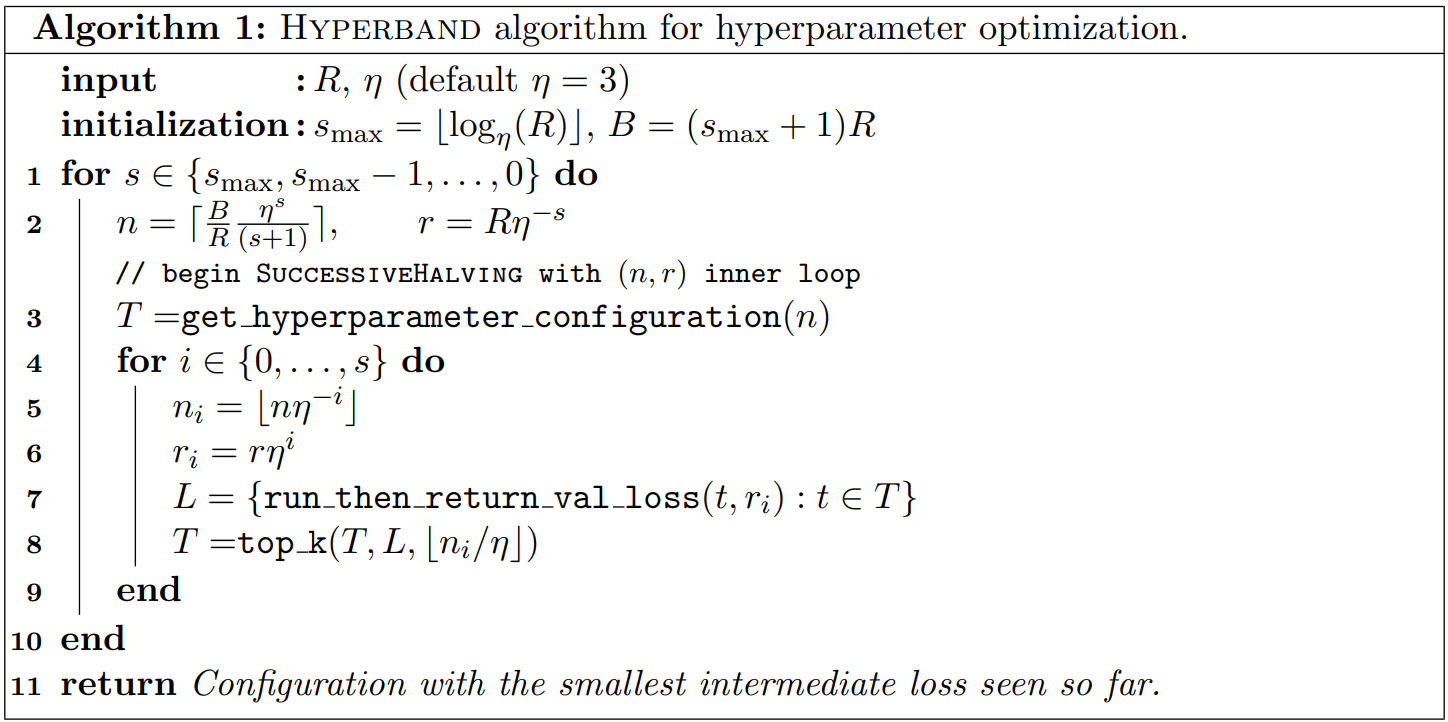

here is how to use it
https://www.tensorflow.org/tutorials/keras/keras_tuner#:~:text=The%20Keras%20Tuner%20is%20a,called%20hyperparameter%20tuning%20or%20hypertuning.

Let’s use LSTM sequential modeling with word embedding

# LSTM's

## Basic Overview

Simple RNN's were certainly better than classical ML algorithms and gave state of the art results, but it failed to capture long term dependencies that is present in sentences . So in 1998-99 LSTM's were introduced to counter to these drawbacks.

## In Depth Understanding

Why LSTM's?
* https://www.coursera.org/learn/nlp-sequence-models/lecture/PKMRR/vanishing-gradients-with-rnns
* https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/

What are LSTM's?
* https://www.coursera.org/learn/nlp-sequence-models/lecture/KXoay/long-short-term-memory-lstm
* https://distill.pub/2019/memorization-in-rnns/
* https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

# Code Implementation

We have already tokenized and paded our text for input to LSTM's

In [ ]:
from gensim.models import Word2Vec,KeyedVectors
am_model= KeyedVectors.load('Model/cbow_200D')

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))## our embedding has 200 dimension
for word, i in tqdm(word_index.items()):
    if word in am_model.wv.vocab:
      embedding_vector = am_model.wv[word]
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector


Use the bellow code to work with high Performance machine detected
```
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = tf.keras.layers.Sequential()
    model.add(tf.keras.layers.Embedding(len(word_index) + 1,
                     EMBED_SIZE,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(tf.keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()
```



In [ ]:
%%time

# A simple LSTM with our w2v embeddings
model = tf.keras.layers.Sequential()
model.add(tf.keras.layers.Embedding(len(word_index) + 1,
                  EMBED_SIZE,
                  weights=[embedding_matrix],
                  input_length=MAX_LEN,
                  trainable=False))

model.add(tf.keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(xtrain_pad, ytrain, epochs=5, batch_size=64, validation_split=0.1)

In [ ]:
_predict(model)

### Use bidirectional encoding to capture better language context
https://arxiv.org/pdf/1611.06639.pdf

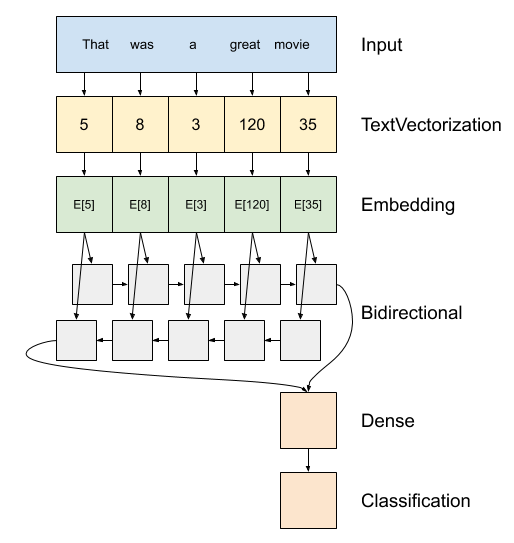

### Sequential Modeling with Attention

Use this link to see all code code base implementation for attention techniques defined in the slide #code from https://github.com/sujitpal/eeap-examples/blob/master/src/custom_attn.py


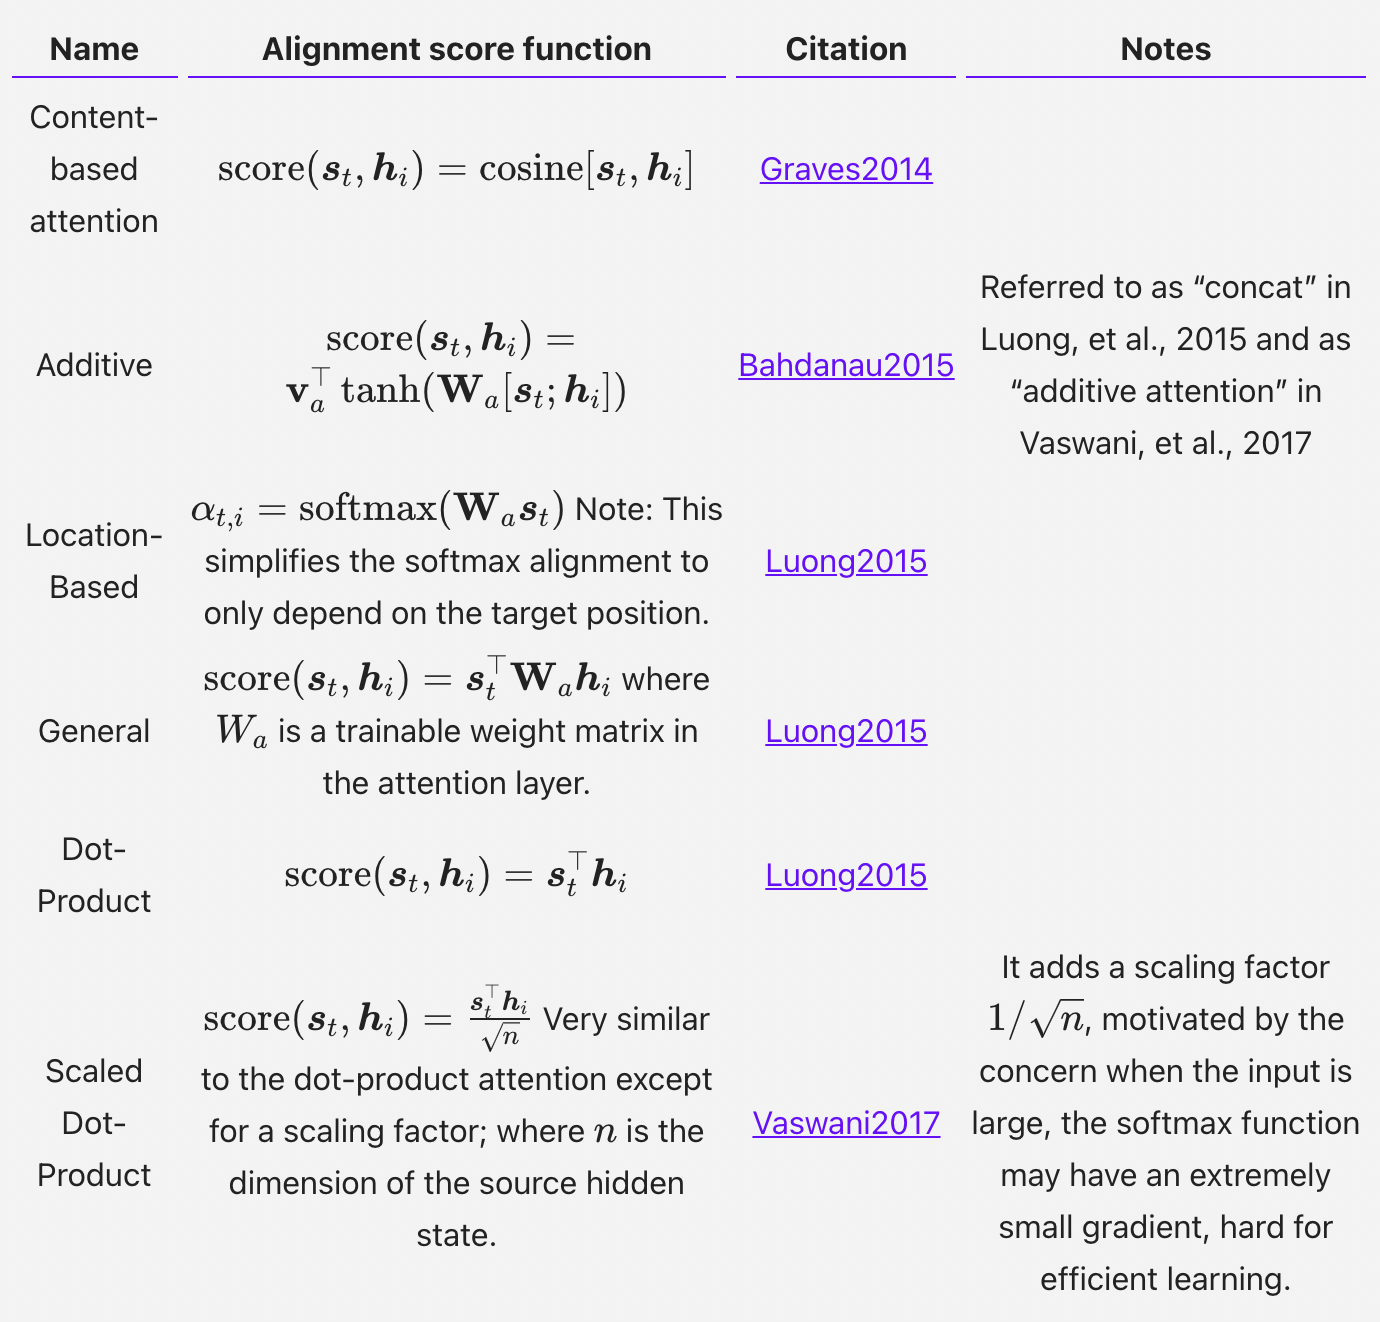

In [39]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [40]:
### Additive Attention 
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [50]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [51]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)


In [52]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(NUM_CLASSES, activation="softmax")(dropout) 
model = keras.Model(inputs=sequence_input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 250, 200)     1200000     ['input_2[0][0]']                
                                                                                                  
 bi_lstm_0 (Bidirectional)      (None, 250, 64)      59648       ['embedding_4[0][0]']            
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 250, 64),    24832       ['bi_lstm_0[0][0]']              
                                 (None, 32),                                                

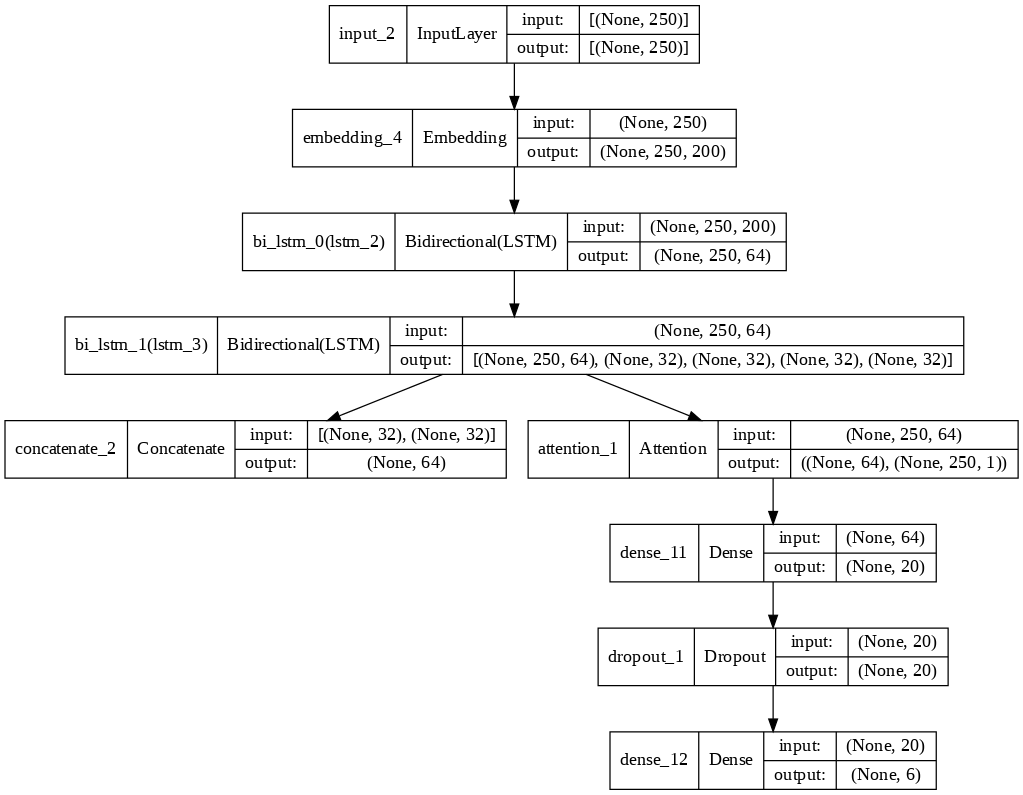

In [53]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [55]:
xtrain_pad.shape

(41185, 6738)

In [ ]:
BATCH_SIZE = 100
EPOCHS = 1
history = model.fit(xtrain_pad, ytrain,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1)

In [ ]:
_predict(model)

### [Hierarchical encoding](https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf) for document modeling

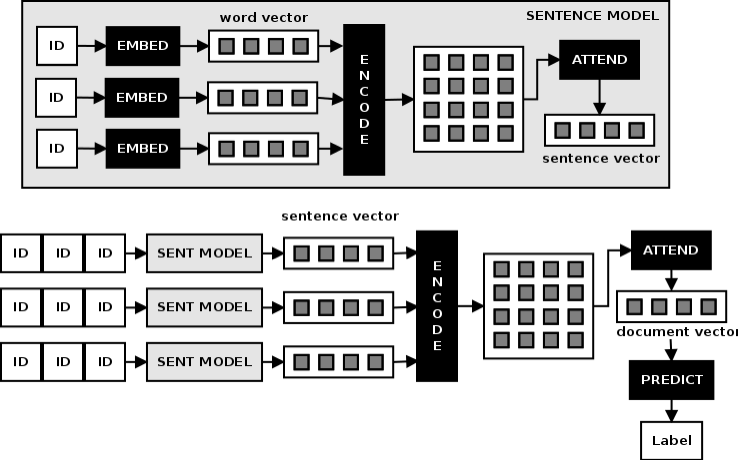

# Transformers : Attention is all you need

So finally we have reached the end of the learning curve and are about to start learning the technology that changed NLP completely and are the reasons for the state of the art NLP techniques .Transformers were introduced in the paper Attention is all you need by Google. If you have understood the Attention models,this will be very easy , Here is transformers fully explained:

* http://jalammar.github.io/illustrated-transformer/

## Code Implementation

* http://nlp.seas.harvard.edu/2018/04/03/attention.html ---> This presents the code implementation of the architecture presented in the paper by Google

# Working with BERT

As Promised I am back with Resiurces , to understand about BERT architecture , please follow the contents in the given order :-

* http://jalammar.github.io/illustrated-bert/ ---> In Depth Understanding of BERT

After going through the post Above , I guess you must have understood how transformer architecture have been utilized by the current SOTA models . Now these architectures can be used in two ways :<br><br>
1) We can use the model for prediction on our problems using the pretrained weights without fine-tuning or training the model for our sepcific tasks
* EG: http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/ ---> Using Pre-trained BERT without Tuning

2) We can fine-tune or train these transformer models for our task by tweaking the already pre-trained weights and training on a much smaller dataset
* EG:* https://www.youtube.com/watch?v=hinZO--TEk4&t=2933s ---> Tuning BERT For your TASK

We will be using the first example as a base for our implementation of BERT model using Hugging Face and KERAS , but contrary to first example we will also Fine-Tune our model for our task

Acknowledgements : https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras


Steps Involved :
* Data Preparation : Tokenization and encoding of data
* Configuring TPU's 
* Building a Function for Model Training and adding an output layer for classification
* Train the model and get the results

Here is nicely detailed article to use BERT model from huggingface
https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

### Try Amharic Roberta model to train the same task and check its performance. https://huggingface.co/uhhlt/am-roberta